# SC1015 Project Notebook 3

* [Importing Libraries and Dataset](#Importing-Libraries-and-Dataset)
* [Random Forest](#Random-Forest)
    * [Running Simple RandomForest](#Running-Simple-RandomForest)
        * [Predicting on Train Data](#simple_train)
        * [Predicting on Test Data](#simple_test)
    * [Running RandomForest with Larger Hyperparameters](#Running-RandomForest-with-Larger-Hyperparameters)
        * [Predicting on Train Data](#larger_train)
        * [Predicting on Test Data](#larger_test)
    * [Fighting Class Imbalance and Cross-Validating](#Fighting-Class-Imbalance-and-Cross-Validating)
        * [Downsampling Negative Stroke Events](#Downsampling-Negative-Stroke-Events)
        * [Using RandomizedSearchCV](#Using-RandomizedSearchCV)
        * [Predicting with RandomizedSearchCV on Downsampled Test Data](#Predicting-with-RandomizedSearchCV-on-Downsampled-Test-Data)
        * [Using GridSearchCV](#Using-GridSearchCV)
        * [Predicting with GridSearchCV on Downsampled Test Data](#Predicting-with-GridSearchCV-on-Downsampled-Test-Data)
    * [Looking at Feature Importance](#Looking-at-Feature-Importance)
* [Logistic Regression](#Logistic-Regression)
    * [Simple Logistic Regression](#Simple-Logistic-Regression)
    * [Logistic Regression with Cross-Validation on Downsampled Data](#Logistic-Regression-with-Cross-Validation-on-Downsampled-Data)
* [Conclusion](#Conclusion)

---
#### Importing Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
import seaborn as sb
sb.set()

import matplotlib.pyplot as plt 

In [3]:
# helper function to print markdown from python
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('&nbsp;' + string.replace('\n','<br>')))

In [4]:
mldata = pd.read_csv('mldata.csv')
mldata

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type__Govt_job,work_type__Private,work_type__Self-employed,work_type__children
0,1,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0
1,0,61.0,0,0,1,0,202.21,28.3,1,0,0,1,0
2,1,80.0,0,1,1,0,105.92,32.5,1,0,1,0,0
3,0,49.0,0,0,1,1,171.23,34.4,1,0,1,0,0
4,0,79.0,1,0,1,0,174.12,24.0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,0,80.0,1,0,1,1,83.75,28.3,0,0,1,0,0
5083,0,81.0,0,0,1,1,125.20,40.0,0,0,0,1,0
5084,0,35.0,0,0,1,0,82.99,30.6,0,0,0,1,0
5085,1,51.0,0,0,1,0,166.29,25.6,0,0,1,0,0


---
## Random Forest
`Random Forest` is a *Supervised* Machine Learning Algorithm. It builds on decision trees on different samples and takes the majority vote through collaborating learning between multiple trees. We use a classifier because we ultimately want to predict `stroke` which is discrete. The `Isolation Forest` that we saw in the previous notebook was based on this, so let's see what it can tell us about predicting `stroke`. 

In [5]:
# Import essential models and functions from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [6]:
# Utility Function to predict and display accuracy measures
def random_forest(rforest,X,y,data_type):
    # Predict the Response corresponding to Predictors
    y_pred = rforest.predict(X)

    # Print the Classification Accuracy
    printmd("**{} Data**".format(data_type))
    print("Accuracy  :\t", rforest.score(X, y))
    print()

    # Print the Accuracy Measures from the Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    tp = cm[1][1] # True Positives : Good (1) predicted Good (1)
    fp = cm[0][1] # False Positives : Bad (0) predicted Good (1)
    tn = cm[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fn = cm[1][0] # False Negatives : Good (1) predicted Bad (0)

    print("TPR {} :\t".format(data_type), (tp/(tp + fn)))
    print("TNR {} :\t".format(data_type), (tn/(tn + fp)))
    print()

    print("FPR {} :\t".format(data_type), (fp/(tn + fp)))
    print("FNR {} :\t".format(data_type), (fn/(tp + fn)))
    
    # Plot the two-way Confusion Matrix
    printmd("**Confusion Matrix**")
    sb.heatmap(confusion_matrix(y, y_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18})
    plt.show()
    
    # View the classification report for train data and predictions
    printmd("**Classification Report**")
    print(classification_report(y, y_pred, zero_division=1))
    
    if data_type == 'Test':
        printmd("**AUC-ROC Curve**")
        y_pred_proba = rforest.predict_proba(X)[::,1]
        fpr, tpr, _ = roc_curve(y,  y_pred_proba)
        auc = roc_auc_score(y, y_pred_proba)
        plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
        plt.legend(loc=5)
        plt.show()

---
### Running Simple RandomForest
Let's begin by splitting the dataset into train and test

In [7]:
# Extract Response and Predictors
y = pd.DataFrame(mldata['stroke'])
X = pd.DataFrame(mldata.drop('stroke', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

In [8]:
# Create the Random Forest object
rforest = RandomForestClassifier(max_depth = 4, random_state = 1) # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.stroke.values.ravel());

---
<a id="simple_train"></a>
#### Predicting on Train Data

&nbsp;**Train Data**

Accuracy  :	 0.9536041939711665

TPR Train :	 0.0
TNR Train :	 1.0

FPR Train :	 0.0
FNR Train :	 1.0


&nbsp;**Confusion Matrix**

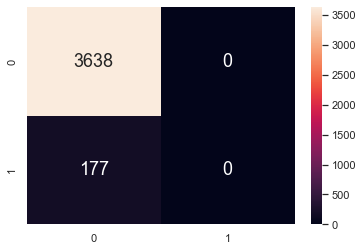

&nbsp;**Classification Report**

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3638
           1       1.00      0.00      0.00       177

    accuracy                           0.95      3815
   macro avg       0.98      0.50      0.49      3815
weighted avg       0.96      0.95      0.93      3815



In [9]:
random_forest(rforest,X_train,y_train,'Train')

Running a default `Random Forest Classifier` with `max_depth` `4` gives us a very poor model on the `train` data even though the overall classification accuracy is `0.95`. The `f1-score` for positive is `0` and everything is predicted as `negative` by the model, with the `TPR` being `0`. 

---
<a id="simple_test"></a>
#### Predicting on Test Data
Let's see how it performs on the `test` data.

&nbsp;**Test Data**

Accuracy  :	 0.9433962264150944

TPR Test :	 0.0
TNR Test :	 1.0

FPR Test :	 0.0
FNR Test :	 1.0


&nbsp;**Confusion Matrix**

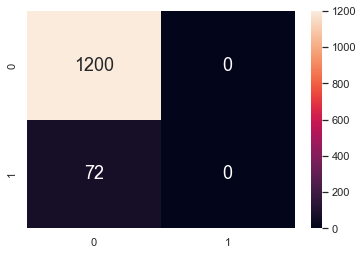

&nbsp;**Classification Report**

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1200
           1       1.00      0.00      0.00        72

    accuracy                           0.94      1272
   macro avg       0.97      0.50      0.49      1272
weighted avg       0.95      0.94      0.92      1272



&nbsp;**AUC-ROC Curve**

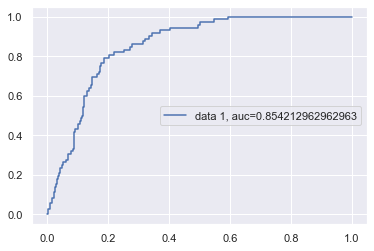

In [10]:
random_forest(rforest,X_test,y_test,'Test')

The performance on the `test` data is equally as bad as the performance on the `train` data <br>
The `AUC-ROC Score` currently stands at `0.85` which is supposed to indicate a good prediction model. However, we know that this is due to the heavy bias towards the majority class of `negative stroke`

---
### Running RandomForest with Larger Hyperparameters
Let's increase some of the basic hyperparameters and see what happens.

In [11]:
# Create the Random Forest object
rforest_new = RandomForestClassifier(n_estimators = 5000, max_depth = 17, random_state = 2) # set the maximum depth of each tree

# Fit Random Forest on Train Data
rforest_new.fit(X_train, y_train.stroke.values.ravel());

---
<a id="larger_train"></a>
#### Predicting on Train Data

&nbsp;**Train Data**

Accuracy  :	 1.0

TPR Train :	 1.0
TNR Train :	 1.0

FPR Train :	 0.0
FNR Train :	 0.0


&nbsp;**Confusion Matrix**

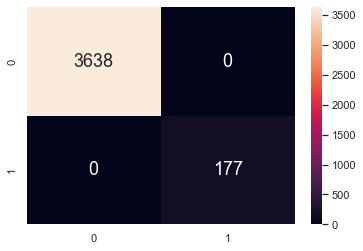

&nbsp;**Classification Report**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3638
           1       1.00      1.00      1.00       177

    accuracy                           1.00      3815
   macro avg       1.00      1.00      1.00      3815
weighted avg       1.00      1.00      1.00      3815



In [12]:
random_forest(rforest_new,X_train,y_train,'Train')

Tuning the parameters seemed to have achieved a perfect prediction of the `train` data. However, it is very likely just overfitting the train data. 

---
<a id="larger_test"></a>
#### Predicting on Test Data
Let's see how it performs on the `test` data. 

&nbsp;**Test Data**

Accuracy  :	 0.9426100628930818

TPR Test :	 0.013888888888888888
TNR Test :	 0.9983333333333333

FPR Test :	 0.0016666666666666668
FNR Test :	 0.9861111111111112


&nbsp;**Confusion Matrix**

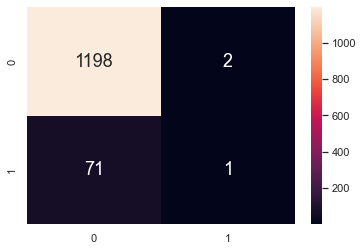

&nbsp;**Classification Report**

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1200
           1       0.33      0.01      0.03        72

    accuracy                           0.94      1272
   macro avg       0.64      0.51      0.50      1272
weighted avg       0.91      0.94      0.92      1272



&nbsp;**AUC-ROC Curve**

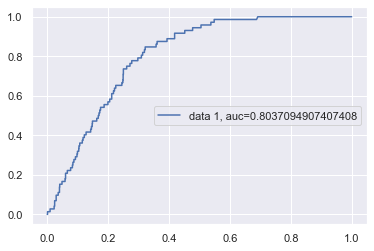

In [13]:
random_forest(rforest_new,X_test,y_test,'Test')

As expected, the model overfits the `train` data due to larger hyperparameters. It performs poorly on the `test` data. It only gets `1` true positive which is an improvement from before, and the `f1-score` for positive has gone up to a mere `0.03`. It also manages to get `2` false positives, bringing down the `f1-score` for negative to `0.97`. The heavy bias towards `stroke = 0` is still present. 

Overall, the `AUC-ROC` score has decreased to `0.80` (from `0.85`).

Given how skewed the `stroke` category is, even `cross-validation` is unlikely to produce a good result. We know from `IsolationForest` that `positive` stroke events are always split early on by a `RandomForest`. So tuning `max_depth` and other hyperparameters is unlikely to help. 

---
### Fighting Class Imbalance and Cross-Validating
The heavy bias in the `RandomForest` can be reduced by scaling either `stroke` class to make them equal. We could then run `RandomForest` on the new scaled dataset and see how it differs. To save time, we will be directly running `Cross-Validation` on this scaled dataset. 

#### Downsampling Negative Stroke Events
Let's make the number of positive and negative stroke events equal by doing some simple downsampling on negative `stroke` events. The reason we have chosen to do so is that if we were to upsample the positive `stroke` values, we would be multiplying the entire set of positive values by almost `18` times, which would significantly increase the number of unique rows repeated. If we were to then train a RandomForest on it, it would be difficult to create a disjoint `train` and `test` set. 

In [14]:
from sklearn.utils import resample

strokeyes = mldata[mldata.stroke == 1]
strokeno = mldata[mldata.stroke == 0]

# Downsample the 0s
strokeno_down = resample(strokeno, random_state=11,
                        replace=False,                     # sample without replacement
                        n_samples=strokeyes.shape[0])      # to match number of 1s
 
# Combine the two classes back after downsample
balanced_data = pd.concat([strokeyes, strokeno_down])
 
# Check the ratio of the classes
balanced_data['stroke'].value_counts()

1    249
0    249
Name: stroke, dtype: int64

---
#### Using RandomizedSearchCV
Instead of directly jumping into `GridSearchCV`, we can first run `RandomizedSearchCV` with a much larger parameter grid to identify where the best parameters could potentially lie. 

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [16]:
# Extract Response and Predictors
by = pd.DataFrame(balanced_data['stroke'])
bX = pd.DataFrame(balanced_data.drop('stroke', axis = 1))

# Split the Dataset into Train and Test
bX_train, bX_test, by_train, by_test = train_test_split(bX, by, test_size = 0.25, random_state=6)

In [17]:
random_grid = {'n_estimators': np.arange(100,1001,100),
               'max_features': ['auto', 'sqrt'],
               'max_depth': np.arange(2, 12),
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

randomCV = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=9), 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3,
                               scoring = 'balanced_accuracy',
                               random_state=4, 
                               n_jobs = -1)

randomCV.fit(bX_train, by_train.stroke.values.ravel());

In [18]:
randomCV.best_params_

{'n_estimators': 900,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 7,
 'bootstrap': True}

These are the best parameters. We can build our grid for `GridSearchCV` around this.
___

#### Predicting with RandomizedSearchCV on Downsampled Test Data

&nbsp;**Test Data**

Accuracy  :	 0.752

TPR Test :	 0.7575757575757576
TNR Test :	 0.7457627118644068

FPR Test :	 0.2542372881355932
FNR Test :	 0.24242424242424243


&nbsp;**Confusion Matrix**

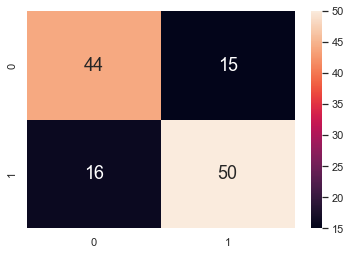

&nbsp;**Classification Report**

              precision    recall  f1-score   support

           0       0.73      0.75      0.74        59
           1       0.77      0.76      0.76        66

    accuracy                           0.75       125
   macro avg       0.75      0.75      0.75       125
weighted avg       0.75      0.75      0.75       125



&nbsp;**AUC-ROC Curve**

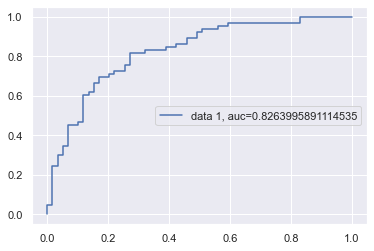

In [19]:
random_forest(randomCV.best_estimator_,bX_test,by_test,'Test')

Even though the `f1-score` is lower, reducing the bias has created a much better model. Both `TPR` and `TNR` are around `0.75` which is more meaningful than one being a perfect `1` while the other being an equally useless `0`. The `AUC-ROC` score is `0.83`. 

---
#### Using GridSearchCV
This model may further improve if we now use `GridSearchCV` with the best parameters obtained from `RandomizedSearchCV`

In [20]:
# Define the Hyper-parameter Grid to search on
param_grid = { 'n_estimators': [800, 900, 1300],  
                'max_depth': [5, 7, 9],             
                'max_features': ['auto'],              
                'min_samples_split': [4, 5, 6],           
                'min_samples_leaf': [1, 2],             
                'bootstrap': [True]                
              } 

# Create the Hyper-parameter Grid
grid_CV = GridSearchCV(RandomForestClassifier(random_state=7),   # the model family
                      param_grid,                 # the search grid
                      cv = 5,                     # 5-fold cross-validation
                      scoring = 'balanced_accuracy', # score to evaluate
                      n_jobs = -1)       

# Train the models using Cross-Validation
grid_CV.fit(bX_train, by_train.stroke.values.ravel());

In [21]:
# Fetch the best Model or the best set of Hyper-parameters
grid_CV.best_params_

{'bootstrap': True,
 'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 1300}

---
#### Predicting with GridSearchCV on Downsampled Test Data 

&nbsp;**Test Data**

Accuracy  :	 0.76

TPR Test :	 0.7727272727272727
TNR Test :	 0.7457627118644068

FPR Test :	 0.2542372881355932
FNR Test :	 0.22727272727272727


&nbsp;**Confusion Matrix**

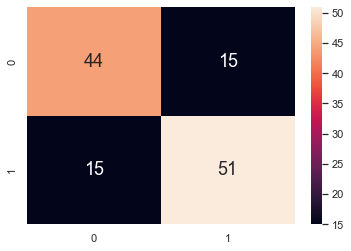

&nbsp;**Classification Report**

              precision    recall  f1-score   support

           0       0.75      0.75      0.75        59
           1       0.77      0.77      0.77        66

    accuracy                           0.76       125
   macro avg       0.76      0.76      0.76       125
weighted avg       0.76      0.76      0.76       125



&nbsp;**AUC-ROC Curve**

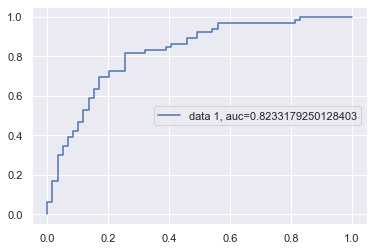

In [22]:
random_forest(grid_CV.best_estimator_,bX_test,by_test,'Test')

The model has improved very slightly in comparison to `RandomizedSearchCV`. The`f1-score` and `AUC-ROC` scores are about the same and the only difference is `1` more `True Positive` and `1` less `False Negative`. 

---
### Looking at Feature Importance
The objective of using `RandomForest` wasn't exactly to get the best prediction model, but rather a decent model and to then see which features are most important in predicting it. 

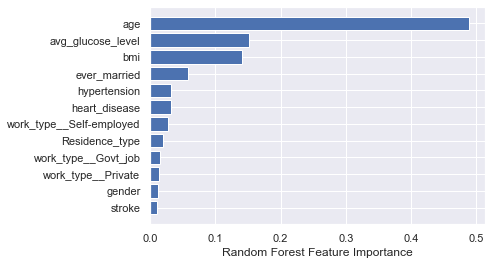

In [23]:
sorted_ids = grid_CV.best_estimator_.feature_importances_.argsort()
plt.barh(mldata.columns[sorted_ids], grid_CV.best_estimator_.feature_importances_[sorted_ids])
plt.xlabel("Random Forest Feature Importance");

The raw feature importances show `age`, `avg_glucose` and `bmi` having the highest importance and this is due to `RandomForest` using variables with higher cardinality to make decisions more often. `Permutation Importance` would be a better measure of feature importance. Permutation feature importance looks at how the model score changes after randomly shuffling a single feature to see what impact that feature has on the model.

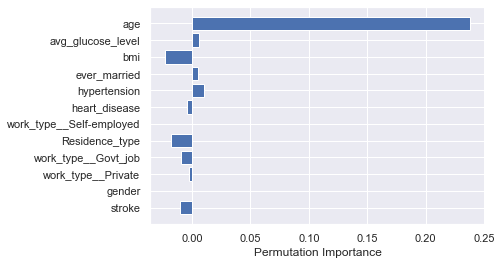

In [24]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(grid_CV.best_estimator_,bX_test,by_test,n_repeats=10,random_state=13,n_jobs=-1,scoring='balanced_accuracy')
plt.barh(mldata.columns[sorted_ids], perm_importance.importances_mean[sorted_ids])
plt.xlabel("Permutation Importance");

Permutation Importance says that `age` is the most useful feature when it comes to predicting `stroke`. It is also the only feature with a decent importance value. Other variables have very low importance values in comparison.

---
## Logistic Regression
It would be a good idea to have a quick look at how other families of models perform at stroke prediction. Both `IsolationForest` and `RandomForest` are tree-based models unlike `Logistic Regression`, which is a linear regression model. We can use `Logistic Regression` since it is meant for predicting discrete variables.

---
#### Simple Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
logistic_regression = random_forest # both models can be evaluated in the same manner

In [27]:
# logistic regression object
lr = LogisticRegression(max_iter = 1000, random_state = 19, n_jobs = -1)

# Make new test-train splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=133)

# train the model on train set
lr.fit(X_train, y_train.values.ravel());

&nbsp;**Train Data**

Accuracy  :	 0.9536041939711665

TPR Train :	 0.0
TNR Train :	 1.0

FPR Train :	 0.0
FNR Train :	 1.0


&nbsp;**Confusion Matrix**

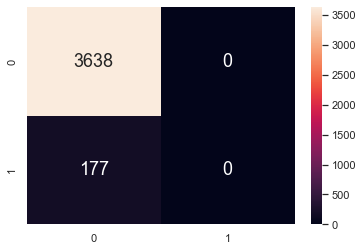

&nbsp;**Classification Report**

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3638
           1       1.00      0.00      0.00       177

    accuracy                           0.95      3815
   macro avg       0.98      0.50      0.49      3815
weighted avg       0.96      0.95      0.93      3815



In [28]:
logistic_regression(lr,X_train,y_train,'Train')

&nbsp;**Test Data**

Accuracy  :	 0.9433962264150944

TPR Test :	 0.0
TNR Test :	 1.0

FPR Test :	 0.0
FNR Test :	 1.0


&nbsp;**Confusion Matrix**

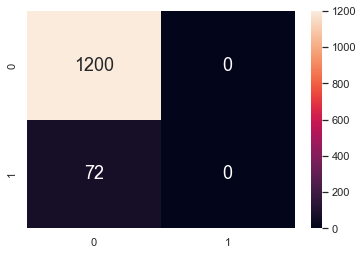

&nbsp;**Classification Report**

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1200
           1       1.00      0.00      0.00        72

    accuracy                           0.94      1272
   macro avg       0.97      0.50      0.49      1272
weighted avg       0.95      0.94      0.92      1272



&nbsp;**AUC-ROC Curve**

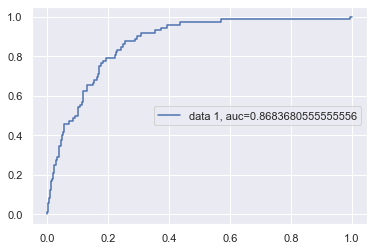

In [29]:
logistic_regression(lr,X_test,y_test,'Test')

We can see that `LogisticRegression` performs just as poorly as `RandomForest` on the original `mldata` dataset without any upsampling. 

---
#### Logistic Regression with Cross-Validation on Downsampled Data

In [30]:
random_grid_lr = {
    'max_iter': [10000],                      
    'solver': ['newton-cg', 'liblinear', 'saga' ], 
    'class_weight': ['balanced'],
    'C': [0.1, 0.5, 1,10,15,20], 
    'penalty': ['l2']
}

random_lr_CV = RandomizedSearchCV(estimator = LogisticRegression(random_state=90), 
                               param_distributions = random_grid_lr, 
                               n_iter = 18, 
                               cv = 3,
                               scoring = 'balanced_accuracy',
                               random_state=40, 
                               n_jobs = -1)

random_lr_CV.fit(bX_train, by_train.stroke.values.ravel());

In [31]:
random_lr_CV.best_params_

{'solver': 'liblinear',
 'penalty': 'l2',
 'max_iter': 10000,
 'class_weight': 'balanced',
 'C': 10}

&nbsp;**Test Data**

Accuracy  :	 0.768

TPR Test :	 0.7878787878787878
TNR Test :	 0.7457627118644068

FPR Test :	 0.2542372881355932
FNR Test :	 0.21212121212121213


&nbsp;**Confusion Matrix**

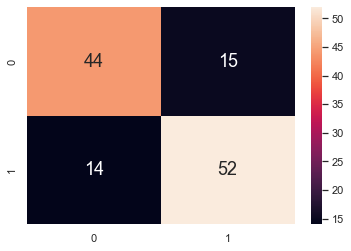

&nbsp;**Classification Report**

              precision    recall  f1-score   support

           0       0.76      0.75      0.75        59
           1       0.78      0.79      0.78        66

    accuracy                           0.77       125
   macro avg       0.77      0.77      0.77       125
weighted avg       0.77      0.77      0.77       125



&nbsp;**AUC-ROC Curve**

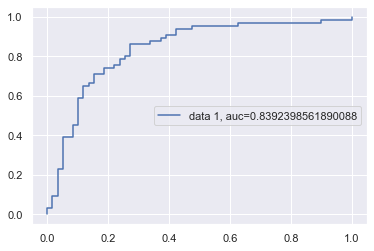

In [32]:
logistic_regression(random_lr_CV.best_estimator_,bX_test,by_test,'Test')

In [34]:
# Define the Hyper-parameter Grid to search on
param_lr_grid = {'solver': ['liblinear'],
                 'penalty': ['l2'],
                 'max_iter': [10000, 12000, 15000],
                 'class_weight': ['balanced'],
                 'C': [10, 12, 14]} 

# Create the Hyper-parameter Grid
lr_grid_CV = GridSearchCV(LogisticRegression(random_state=70),  
                      param_lr_grid,                 
                      cv = 5,                     
                      scoring = 'balanced_accuracy', 
                      n_jobs = -1)       

# Train the models using Cross-Validation
lr_grid_CV.fit(bX_train, by_train.stroke.values.ravel());

In [35]:
lr_grid_CV.best_params_

{'C': 10,
 'class_weight': 'balanced',
 'max_iter': 10000,
 'penalty': 'l2',
 'solver': 'liblinear'}

&nbsp;**Test Data**

Accuracy  :	 0.768

TPR Test :	 0.7878787878787878
TNR Test :	 0.7457627118644068

FPR Test :	 0.2542372881355932
FNR Test :	 0.21212121212121213


&nbsp;**Confusion Matrix**

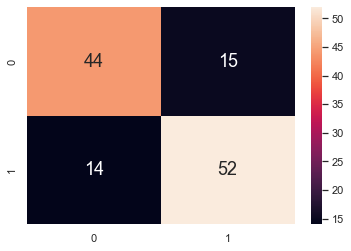

&nbsp;**Classification Report**

              precision    recall  f1-score   support

           0       0.76      0.75      0.75        59
           1       0.78      0.79      0.78        66

    accuracy                           0.77       125
   macro avg       0.77      0.77      0.77       125
weighted avg       0.77      0.77      0.77       125



&nbsp;**AUC-ROC Curve**

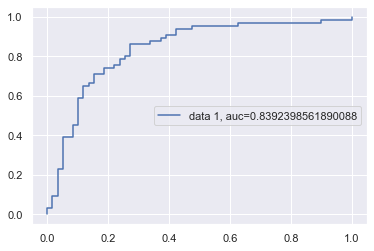

In [36]:
logistic_regression(lr_grid_CV.best_estimator_,bX_test,by_test,'Test')

The prediction of `LogisticRegression` is very similar to `RandomForest`'s even on the downsampled dataset. 

---
## Conclusion

We first explored the `stroke` dataset. <br>
Then we used `IsolationForest` to determine that having a `stroke` is highly likely to be an anomaly. <br>
The poor performance of both `RandomForest` and `LogisticRegression` in predicting `stroke` further substantiated this claim. 

**Does this mean there is nothing we can do about it?** <br>
There is still scope for more analysis. For example, we can try to identify people who have a more than normal risk of having a `stroke`. The people who are at risk of having a stroke may still be considered an anomaly, but it highlights the possibility of having a stroke, and taking care of oneself accordingly. We don't necessarily have to be able to predict it accurately for doing so.  From our `EDA` and `RandomForest`'s feature importances, we know that people over the `age` of `60` or those with `hypertension` and `heart disease` can be considered at-risk. We also know that `gender` has nothing to do with having a stroke. Both groups are equally at-risk. This can be done properly using a clustering model.